# 1. Exploration des Données (EDA) - Détection de Fraude

Ce notebook a pour objectif de réaliser une première analyse exploratoire sur le jeu de données `creditcard.csv`.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Initialisation de la Session Spark

In [2]:
spark = SparkSession.builder \
    .appName("EDA_Fraud_Detection") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print(f"Session Spark démarrée (Version: {spark.version})")

25/11/07 16:25:47 WARN Utils: Your hostname, laureal-Inspiron-7306-2n1 resolves to a loopback address: 127.0.1.1; using 10.223.205.49 instead (on interface wlp0s20f3)
25/11/07 16:25:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/07 16:25:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Session Spark démarrée (Version: 3.4.1)


## Chargement des Données

In [ ]:
data_path = "../data/raw/creditcard.csv"

df = spark.read.csv(data_path, header=True, inferSchema=True)

print(f"Dataset chargé. Nombre de lignes : {df.count()}")
print(f"Nombre de colonnes : {len(df.columns)}")

25/11/07 16:26:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Inspection du Schéma

In [4]:
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

## Statistiques Descriptives

In [5]:
df.select("Time", "Amount", "Class").describe().show()

+-------+------------------+------------------+--------------------+
|summary|              Time|            Amount|               Class|
+-------+------------------+------------------+--------------------+
|  count|            284807|            284807|              284807|
|   mean| 94813.85957508067| 88.34961925093698|0.001727485630620034|
| stddev|47488.145954566266|250.12010924018836|0.041527189635464895|
|    min|               0.0|               0.0|                   0|
|    max|          172792.0|          25691.16|                   1|
+-------+------------------+------------------+--------------------+



## Analyse de la Variable Cible (Class)

Le déséquilibre des classes est extrêmement important pour ce projet.

In [6]:
class_distribution = df.groupBy("Class").agg(
    count("*").alias("count")
).withColumn("percentage", col("count") / df.count() * 100)

class_distribution.show()

+-----+------+------------------+
|Class| count|        percentage|
+-----+------+------------------+
|    1|   492|0.1727485630620034|
|    0|284315| 99.82725143693798|
+-----+------+------------------+



## Visualisation du Déséquilibre des Classes

/tmp/ipykernel_524799/3120826088.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pd_class_dist, x='Class', y='count', palette='Set2')


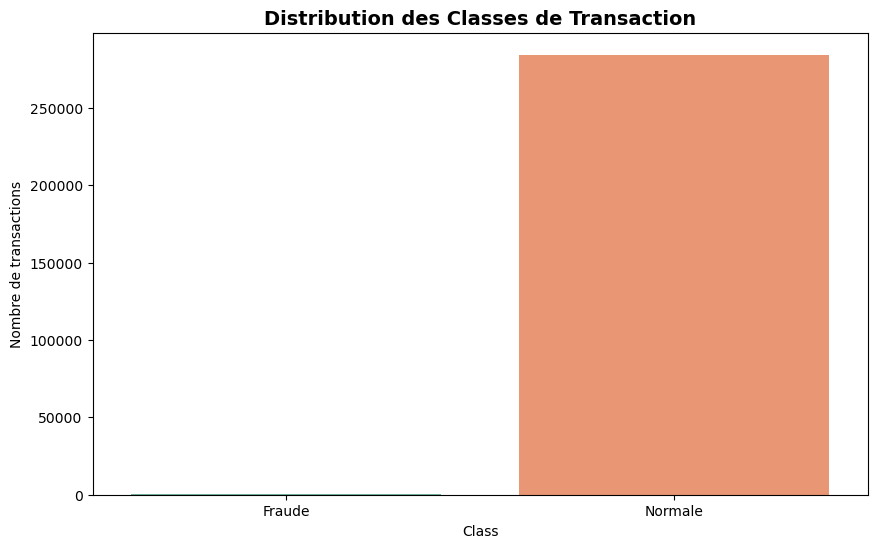


Résumé du déséquilibre :
     Class   count  percentage
0   Fraude     492    0.172749
1  Normale  284315   99.827251


In [7]:
pd_class_dist = class_distribution.toPandas()
pd_class_dist['Class'] = pd_class_dist['Class'].apply(lambda x: 'Normale' if x == 0 else 'Fraude')

plt.figure(figsize=(10, 6))
sns.barplot(data=pd_class_dist, x='Class', y='count', palette='Set2')
plt.title('Distribution des Classes de Transaction', fontsize=14, fontweight='bold')
plt.ylabel('Nombre de transactions')
plt.show()

print("\nRésumé du déséquilibre :")
print(pd_class_dist)

## Conclusion

On observe un déséquilibre extrême : moins de 0.2% de transactions frauduleuses. Cela justifie l'utilisation de métriques comme l'Aire sous la courbe PR (Precision-Recall) plutôt que l'accuracy simple.

In [8]:
spark.stop()